# Heart Failure Prediction Project


Let's import the libraries we will use

In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

# 1. Introduction

#### Datatset
- This dataset is obtained from Kaggle: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

#### Context
- Cardiovascular disease (CVDs) is the number one cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of five CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs.
- People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management.  
- This dataset contains 11 features that can be used to predict possible heart disease.

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

Let's now load the dataset. As we can see above, the variables below Are **categorical**, so we must one-hot encode them. 

- Sex
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope



In [3]:
# read data
df = pd.read_csv("heart.csv")

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


We must perform some data engineering before working with the models. There are 5 categorical features, so we will use Pandas to one-hot encode them.

## 2. One-hot encoding using Pandas

First we will remove the binary variables, because one-hot encoding them would do nothing to them. To achieve this we will just count how many different values there are in each categorical variable and consider only the variables with 3 or more values.

In [5]:
cat_variables = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']

one-hot encoding aims to transform a categorical variable with `n` outputs into `n` binary variables.

Pandas has a built-in method to one-hot encode variables, it is the function `pd.get_dummies`.

 - data: DataFrame to be used
 - prefix: A list with prefixes, so we know which value we are dealing with
 - columns: the list of columns that will be one-hot encoded. 'prefix' and 'columns' must have the same length.
 

In [6]:
# This will replace the columns with the one-hot encoded ones and keep the columns outside 'columns' argument as it is.
df = pd.get_dummies(data = df,prefix = cat_variables,columns = cat_variables)

In [7]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


Let's choose the variables that will be the input features of the model.
- The target is `HeartDisease`.
- All other variables are features that can potentially be used to predict the target, `HeartDisease`.

In [8]:
features = [x for x in df.columns if x not in 'HeartDisease'] ## Removing our target variable

In [9]:
print(len(features))
print(features)

20
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


# 3. Splitting the Dataset

In this section, we will split our dataset into train and test datasets. We will use the function `train_test_split` from Scikit-learn.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(df[features],df["HeartDisease"],random_state=RANDOM_STATE,train_size=0.8)

In [11]:
print(f'train samples: {len(X_train)}\nvalidation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')
print(y_train.shape)
print(y_val.shape)
print(X_train.shape)
print(X_val.shape)


train samples: 734
validation samples: 184
target proportion: 0.5518
(734,)
(184,)
(734, 20)
(184, 20)


# 4. Building the Models



In [12]:
# we will need it later for comparsing the accuracy 
accuracies = {}

## 4.1 Decision Tree

In this section, let's work with the Decision Tree. [Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 


The hyperparameters we will use and investigate here are:

 - min_samples_split: The minimum number of samples required to split an internal node. 
   - Choosing a higher min_samples_split can reduce the number of splits and may help to reduce overfitting.
 - max_depth: The maximum depth of the tree. 
   - Choosing a lower max_depth can reduce the number of splits and may help to reduce overfitting.

In [13]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] 
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

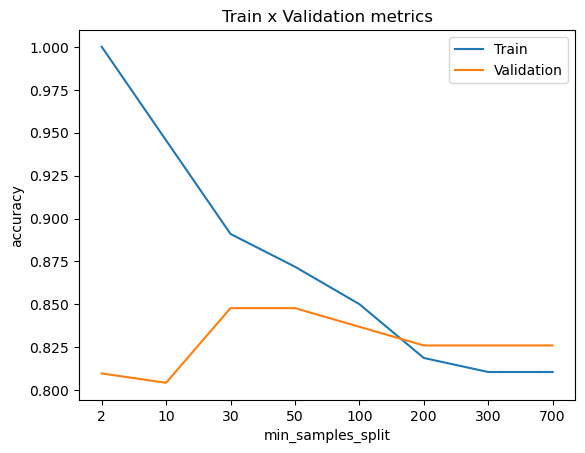

In [14]:
accuracy_list_train = []
accuracy_list_val = []

for min_samples_split in min_samples_split_list:
    
    # fit the model
    model = DecisionTreeClassifier(min_samples_split=min_samples_split,random_state=RANDOM_STATE).fit(X_train,y_train)
    
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel("min_samples_split")
plt.ylabel('accuracy')
plt.xticks(range(len(min_samples_split_list)),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])


Note how increasing the the number of `min_samples_split` reduces overfitting.
- Increasing `min_samples_split` from 10 to 30, and from 30 to 50, even though it does not improve the validation accuracy, it brings the training accuracy closer to it, showing a reduction in overfitting.

Let's do the same experiment with `max_depth`.

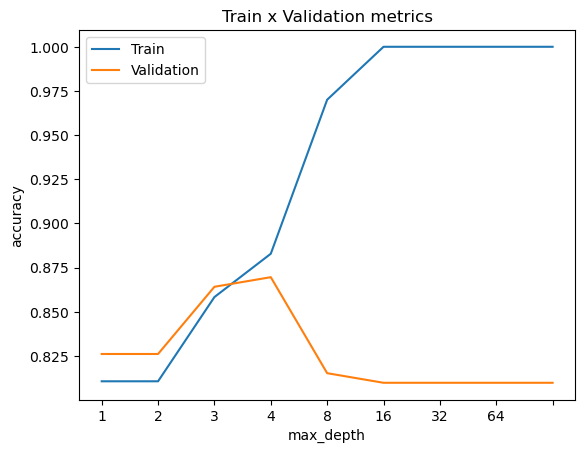

In [16]:
accuracy_list_train = []
accuracy_list_val = []

for max_depth in max_depth_list:
    
    # fit the model 
    model = DecisionTreeClassifier(max_depth = max_depth,random_state = RANDOM_STATE).fit(X_train,y_train) 
    
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

We can see that in general, reducing `max_depth` can help to reduce overfitting.
- Reducing `max_depth` from 8 to 4 increases validation accuracy closer to training accuracy, while significantly reducing training accuracy.
- The validation accuracy reaches the highest at tree_depth=4. 
- When the `max_depth` is smaller than 3, both training and validation accuracy decreases.  The tree cannot make enough splits to distinguish positives from negatives (the model is underfitting the training set). 
- When the `max_depth` is too high ( >= 5), validation accuracy decreases while training accuracy increases, indicating that the model is overfitting to the training set.

So we can choose the best values for these two hyper-parameters for our model to be:
- `max_depth = 4`
- `min_samples_split = 50` 

In [17]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 3,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [18]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8583
Metrics validation:
	Accuracy score: 0.8641


In [19]:
accuracies["Decision Tree"] = 0.864

No sign of overfitting (they are colse to other), even though the metrics are not that good.

## 4.2 Random Forest

Now let's try the Random Forest algorithm also, using the Scikit-learn implementation. 
- All of the hyperparameters found in the decision tree model will also exist in this algorithm, since a random forest is an ensemble of many Decision Trees.
- One additional hyperparameter for Random Forest is called `n_estimators` which is the number of Decision Trees that make up the Random Forest. 


We will run the same script again, but with another parameter, `n_estimators`, where we will choose between 10, 50, and 100. The default is 100.

In [20]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] 
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

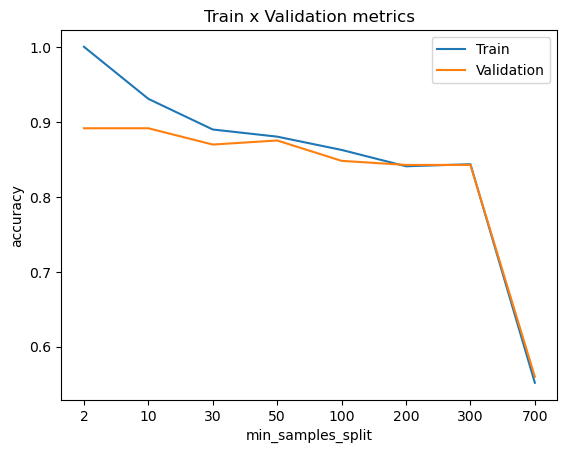

In [21]:
accuracy_list_train = []
accuracy_list_val = []

for min_samples_split in min_samples_split_list:
    
    # fit the model 
    model = RandomForestClassifier(min_samples_split = min_samples_split,random_state = RANDOM_STATE).fit(X_train,y_train) 
    
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

Notice that, even though the validation accuraty reaches is the same both at `min_samples_split = 2` and `min_samples_split = 10`, in the latter the difference in training and validation set reduces, showing less overfitting.

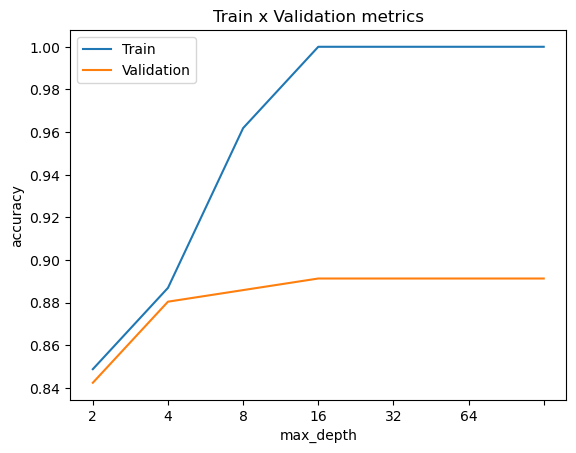

In [22]:
accuracy_list_train = []
accuracy_list_val = []

for max_depth in max_depth_list:
    
    # fit the model
    model = RandomForestClassifier(max_depth = max_depth,random_state = RANDOM_STATE).fit(X_train,y_train) 
    
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

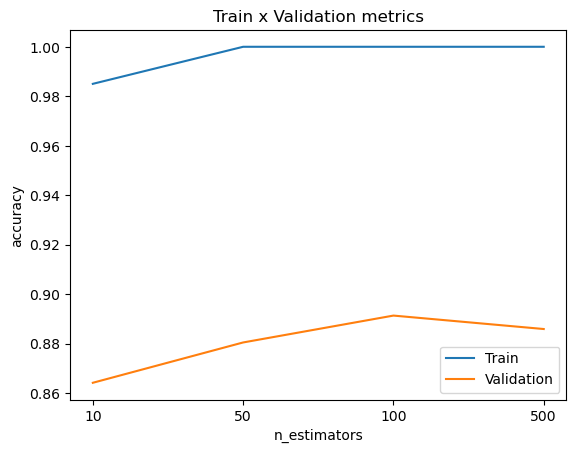

In [23]:
accuracy_list_train = []
accuracy_list_val = []

for n_estimators in n_estimators_list:
    
    # fit the model
    model = RandomForestClassifier(n_estimators = n_estimators,random_state = RANDOM_STATE).fit(X_train,y_train) 
    
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

Let's then fit a random forest with the following parameters:

 - max_depth: 16
 - min_samples_split: 10
 - n_estimators: 100

In [24]:
random_forest_model = RandomForestClassifier(n_estimators = 100,
                                             max_depth = 16, 
                                             min_samples_split = 10).fit(X_train,y_train)

In [25]:
accuracy_train = accuracy_score(random_forest_model.predict(X_train),y_train)
accuracy_val = accuracy_score(random_forest_model.predict(X_val),y_val)

In [26]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_train:.4f}\nMetrics test:\n\tAccuracy score: {accuracy_val:.4f}")

Metrics train:
	Accuracy score: 0.9332
Metrics test:
	Accuracy score: 0.8913


In [27]:
accuracies["Random Forest"] = 0.891

## 4.3 XGBoost

Next is the Gradient Boosting model, called XGBoost. The boosting methods train several trees, but instead of them being uncorrelated to each other, now the trees are fit one after the other in order to minimize the error. 

The model has the same parameters as a decision tree, plus the learning rate.
- The learning rate is the size of the step on the Gradient Descent method that the XGBoost uses internally to minimize the error on each train step.


In [97]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = train_test_split(df[features],df["HeartDisease"],train_size=0.80,random_state=RANDOM_STATE)

We can then set a large number of estimators, because we can stop if the cost function stops decreasing.

Note some of the `.fit()` parameters:
- `early_stopping_rounds`: This parameter helps to stop the model training if its evaluation metric is no longer improving on the validation set. It's set to 400.
  - The model keeps track of the round with the best performance (lowest evaluation metric).  For example, say we set it to 10 and say that round 16 has the lowest evaluation metric so far.
  - Each successive round's evaluation metric is compared to the best metric.  If the model goes 10 rounds where none have a better metric than the best one, then the model stops training.
  - The model is returned at its last state when training terminated, not its state during the best round.  For example, if the model stops at round 26, but the best round was 16, the model's training state at round 26 is returned, not round 16.


In [98]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 400)

[0]	validation_0-logloss:0.63451
[1]	validation_0-logloss:0.59095
[2]	validation_0-logloss:0.55279
[3]	validation_0-logloss:0.51590
[4]	validation_0-logloss:0.48913
[5]	validation_0-logloss:0.46744
[6]	validation_0-logloss:0.44373
[7]	validation_0-logloss:0.42828
[8]	validation_0-logloss:0.41506
[9]	validation_0-logloss:0.39946
[10]	validation_0-logloss:0.38666
[11]	validation_0-logloss:0.37622
[12]	validation_0-logloss:0.36495
[13]	validation_0-logloss:0.35678
[14]	validation_0-logloss:0.35008
[15]	validation_0-logloss:0.34255
[16]	validation_0-logloss:0.33616
[17]	validation_0-logloss:0.33280
[18]	validation_0-logloss:0.32697
[19]	validation_0-logloss:0.32219
[20]	validation_0-logloss:0.31993
[21]	validation_0-logloss:0.31900
[22]	validation_0-logloss:0.31770
[23]	validation_0-logloss:0.31399
[24]	validation_0-logloss:0.31462
[25]	validation_0-logloss:0.31491
[26]	validation_0-logloss:0.31112
[27]	validation_0-logloss:0.31083
[28]	validation_0-logloss:0.31014
[29]	validation_0-loglos

c:\Users\M4TECH\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-logloss:0.30889
[33]	validation_0-logloss:0.30896
[34]	validation_0-logloss:0.30933
[35]	validation_0-logloss:0.30799
[36]	validation_0-logloss:0.30884
[37]	validation_0-logloss:0.30882
[38]	validation_0-logloss:0.31015
[39]	validation_0-logloss:0.31086
[40]	validation_0-logloss:0.31074
[41]	validation_0-logloss:0.31153
[42]	validation_0-logloss:0.31247
[43]	validation_0-logloss:0.31202
[44]	validation_0-logloss:0.31138
[45]	validation_0-logloss:0.31356
[46]	validation_0-logloss:0.31474
[47]	validation_0-logloss:0.31560
[48]	validation_0-logloss:0.31627
[49]	validation_0-logloss:0.31483
[50]	validation_0-logloss:0.31405
[51]	validation_0-logloss:0.31380
[52]	validation_0-logloss:0.31424
[53]	validation_0-logloss:0.31242
[54]	validation_0-logloss:0.31304
[55]	validation_0-logloss:0.31363
[56]	validation_0-logloss:0.31396
[57]	validation_0-logloss:0.31455
[58]	validation_0-logloss:0.31568
[59]	validation_0-logloss:0.31538
[60]	validation_0-logloss:0.31496
[61]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=55, ...)

In [99]:
xgb_model.best_iteration

35

The best round of training was round 35, with a log loss of 0.30799.  


In [100]:
accuracy_train_boost = accuracy_score(xgb_model.predict(X_train),y_train)
accuracy_val_boost = accuracy_score(xgb_model.predict(X_val),y_val)

In [101]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_train_boost:.4f}\nMetrics test:\n\tAccuracy score: {accuracy_val_boost:.4f}")

Metrics train:
	Accuracy score: 0.9673
Metrics test:
	Accuracy score: 0.8859


In [102]:
accuracies["XGBoost"] = 0.886

## 4.4 Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn.preprocessing import StandardScaler

let's normalize our data, note that i made the model without scaling and it give me almost same result

In [40]:
scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train)
X_val_scale = scale.transform(X_val)
print(X_train_scale[:5,:5])

[[ 0.37715866 -2.08166729 -1.79329992  1.78725648  1.73136672]
 [-0.04038954  0.70096573  2.87366437 -0.55951679 -0.28766185]
 [ 0.58593276  0.97922903  0.1167318   1.78725648  0.76067991]
 [ 0.06399751  1.53575563 -0.03643112 -0.55951679 -0.28766185]
 [-0.04038954 -0.13382418 -1.79329992 -0.55951679 -0.67593657]]


In [41]:
clf = LogisticRegression()
clf_model = clf.fit(X_train_scale,y_train)

# predict for train set
yhat1 = clf.predict(X_train_scale)

clf_acurracy1 = accuracy_score(y_train,yhat1)

print(f"acurracy of train set: {clf_acurracy1}")
print(f"f1_score of train set: {f1_score(y_train,yhat1)}")

# predict for val set
yhat2 = clf.predict(X_val_scale)
clf_acurracy2 = accuracy_score(y_val,yhat2)

print(f"acurracy of val set: {clf_acurracy2}")
print(f"f1_score of val set: {f1_score(y_val,yhat2)}")

accuracies["Logistic Regression"] = 0.875

acurracy of train set: 0.8732970027247956
f1_score of train set: 0.8878166465621231
acurracy of val set: 0.875
f1_score of val set: 0.8866995073891626


## 4.5 K-Nearest Neighbour (KNN)

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scale,y_train)

# in the train set
predict1 = knn.predict(X_train_scale)

knn_accuracy1 = accuracy_score(y_train,predict1)
print(f" accuracy of train set: {knn_accuracy1}")

# in the val set
predict2 = knn.predict(X_val_scale)

knn_accuracy2 = accuracy_score(y_val,predict2)
print(f" accuracy of val set: {knn_accuracy2}")


 accuracy of train set: 0.8828337874659401
 accuracy of val set: 0.875


c:\Users\M4TECH\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\M4TECH\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

c:\Users\M4TECH\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\M4TECH\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

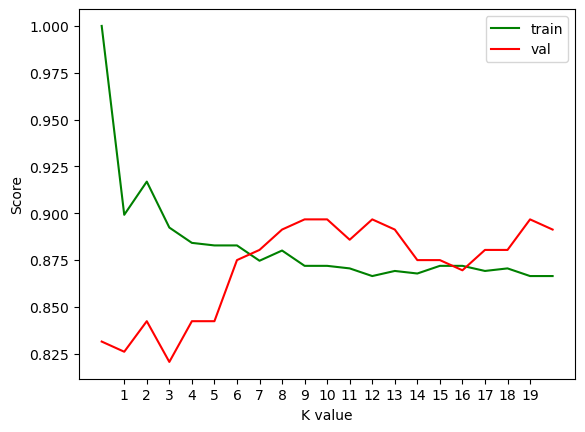

In [44]:
scorelist1 = []
scorelist2 = []

for i in range(1,22,1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scale,y_train)

    # in the train set
    predict1 = knn.predict(X_train_scale)

    knn_accuracy1 = accuracy_score(y_train,predict1)
    scorelist1.append(knn_accuracy1)

    # in the val set
    predict2 = knn.predict(X_val_scale)

    knn_accuracy2 = accuracy_score(y_val,predict2)
    scorelist2.append(knn_accuracy2)
    

plt.plot(scorelist1,'g',scorelist2, 'r')
plt.xticks(np.arange(1,20,1))
plt.gca().legend(('train','val'))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()



In [45]:
# get max score in val set
print(max(map(lambda x : x ,scorelist2)))

accuracies["KNN"] = 0.897

0.8967391304347826


In [79]:
scorelist2[12]   # where i = 12

0.8967391304347826

## 4.6 Naive Bayes 


In [48]:
from sklearn.naive_bayes import GaussianNB

In [50]:
nb = GaussianNB()
nb.fit(X_train_scale,y_train)

# predict for train set
pred1 = nb.predict(X_train_scale)
nb_accuracy1 = accuracy_score(y_train,pred1)
print(f"nb accuracy of train set: {nb_accuracy1}")

# predict for val set
pred2 = nb.predict(X_val_scale)
nb_accuracy2 = accuracy_score(y_val,pred2)
print(f"nb accuracy of val set: {nb_accuracy2}")


nb accuracy of train set: 0.8596730245231607
nb accuracy of val set: 0.875


In [51]:
accuracies["Naive Bayes"] = 0.875

In [103]:
accuracies


{'Decision Tree': 0.864,
 'Random Forest': 0.891,
 'XGBoost': 0.886,
 'Logistic Regression': 0.875,
 'KNN': 0.897,
 'Naive Bayes': 0.875}

## plot the accuracy of the 6 models 

In [54]:
import seaborn as sns

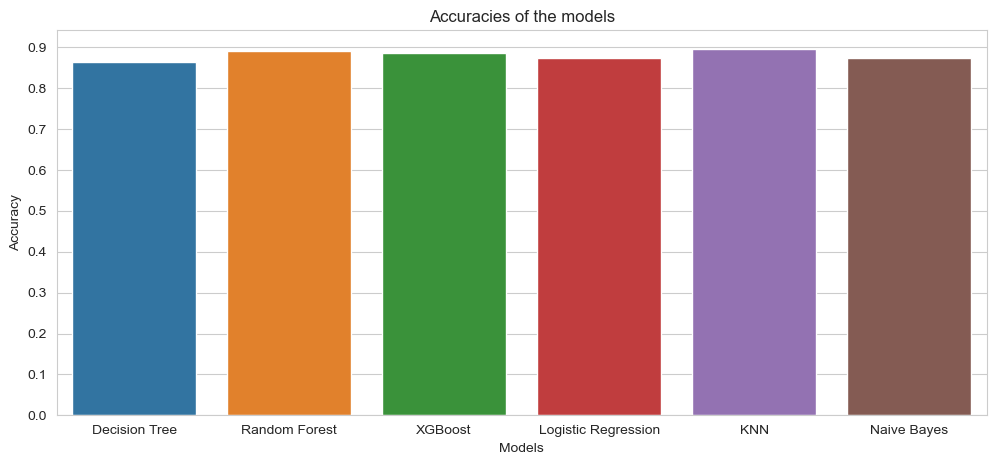

In [104]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.yticks(np.arange(0,1,.1))
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.title("Accuracies of the models")
plt.show()

as we see that `KNN`, `XGBoost`, and `Random Forest` models take the lead